<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brev-xmas-3.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning Microsoft's Phi-2 on your own data 🤙

Welcome!

In this notebook and tutorial, we will fine-tune [Microsoft's Phi-2](https://huggingface.co/microsoft/phi-2) relatively small 2.7B model - which has "showcased a nearly state-of-the-art performance among models with less than 13 billion parameters" - ***on your own data!***

## Watch the accompanying video walk-through (but for Mistral 7B) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)! 
If you'd like to see a notebook to fine-tune Phi-2 on a Hugging Face dataset instead, click [here](https://github.com/brevdev/notebooks/blob/main/phi2-finetune-own-data.ipynb).

I did this for **just one dollar ($1)** on an 1x A10G 24GB from Brev.dev (instructions below).

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
### 0. Preparing data

Before you check out a GPU, prepare your dataset for loading and training.

To prepare your dataset for loading, all you need are two `.jsonl` files structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```
If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will will combine all your features into one input string.

As you can see below, I have `notes.jsonl` for my `train_dataset` and `notes_validation.jsonl` for my `eval_dataset`.

I used Exporter, a free local-only app, to export my Apple Notes to `.txt` files, and then I wrote a script to process each note into one `.jsonl` file. Note that for this script, ChatGPT can help out a LOT if you tell it how your data is currently formatted, how you'd like it to be formatted, and ask it to write a script in a certain language you know well (for any debugging) to do so. I also broke up my journal entries so the training sample vector length was smaller (see the discussion on `max_length` and the data visualization below). I broke it into pieces so that contexts were encapsulated entirely, since I did want the model to understand context about my life. My data were ultimately formatted as:

```json
{"note": "journal-entry-for-model-to-predict"}
{"note": "journal-entry-for-model-to-predict-1"}
{"note": "journal-entry-for-model-to-predict-2"}
```

### 1. Set Up GPU

I used a GPU and dev environment from [brev.dev](https://brev.dev). The whole thing cost me $1 using a 1xA10G 24GB. Click the badge below to get your preconfigured instance:

[![click here to deploy](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=phi2-finetune-own-data&file=https://github.com/brevdev/notebooks/raw/main/phi2-finetune-own-data.ipynb&python=3.10&cuda=12.0.1)

A single A10G (as linked) with 24GB GPU Memory was enough for me. You may need more GPUs and/or Memory if your sequence max_length is larger than 512.

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.0.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [1]:
print(1)

1


In [6]:
!pip install jsonlines

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import jsonlines

phrases = """the sun is playfully golden
clouds are fluffy dreamers
computers are tirelessly calculating
coffee beans are irresistibly aromatic
books are windows to other worlds
bicycles are silently rolling
raindrops are rhythmically tapping
elephants are majestically gentle
fireflies are enchanting the night
roller coasters are thrillingly fast
strawberries are temptingly sweet
dolphins are gracefully swimming
candles are softly flickering
moonlight is romantically silver
penguins are comically waddling
diamonds are dazzlingly brilliant
rivers are serenely flowing
jellyfish are gracefully floating
guitars are passionately strumming
stars are twinkling diamonds
wind is whimsically whispering
ice cream is blissfully creamy
deserts are expansively serene
puzzles are intriguingly challenging
owls are mysteriously hooting
butterflies are delicately fluttering
robots are efficiently buzzing
rainbows are magically colorful
rollerblades are smoothly gliding
volcanoes are powerfully erupting
forests are abundantly green
laughter is contagiously joyful
seashells are intricately patterned
saxophones are soulfully playing
feathers are softly floating
marmalade is delightfully sticky
snowflakes are uniquely delicate
hammocks are lazily swinging
fireworks are explosively vibrant
marshmallows are perfectly fluffy
comets are speedily streaking
trampolines are bouncily springing
cherry blossoms are gracefully falling
hummingbirds are swiftly darting
sunsets are breathtakingly colorful
hot air balloons are peacefully drifting
acrobats are daringly flipping
canyons are grandly echoing
bubbles are playfully floating
kangaroos are energetically hopping
auroras are ethereally dancing
lightning is dramatically striking
popcorn is irresistibly buttery
giraffes are elegantly towering
sandcastles are creatively sculpted
peacocks are regally displaying
tulips are gracefully nodding
meteors are spectacularly streaking
spiders are intricately weaving
thunder is rumbling mysteriously
seagulls are gracefully gliding
marshes are peacefully teeming
tornadoes are ominously swirling
dolphins are joyfully leaping
lighthouses are steadfastly shining
avalanches are powerfully cascading
strawberries are temptingly juicy
zebras are strikingly patterned""".split("\n")


with jsonlines.open('notes.jsonl', 'w') as writer:
    for i, phrase in enumerate(phrases):
        entry_format = {"note": f"{phrase}"}
        writer.write(entry_format)


In [4]:
import jsonlines

phrases = """kites are soaring gracefully
eagles are majestically soaring
bonsai trees are intricately pruned
bumblebees are industriously buzzing
rainforests are abundantly vibrant
dragonflies are delicately hovering
waterfalls are thunderously cascading
sunflowers are cheerfully blooming
snowmen are whimsically adorned
sand dunes are expansively shifting
crickets are chirping rhythmically
cacti are resiliently standing
symphonies are harmoniously playing
polar bears are magnificently white
caterpillars are industriously crawling
comets are mysteriously glowing
glaciers are slowly advancing
igloos are cozily constructed
metropolises are bustling with energy
fireflies are romantically twinkling
satellites are silently orbiting
orchids are elegantly blooming
robots are diligently computing
hurricanes are powerfully swirling
dolphins are gracefully flipping
tigers are stealthily prowling
strawberries are lusciously ripe
snowflakes are intricately formed
eagles are majestically soaring
sandcastles are playfully sculpted
moonlight is softly illuminating
fireworks are explosively dazzling""".split("\n")


with jsonlines.open('notes_validation.jsonl', 'w') as writer:
    for i, phrase in enumerate(phrases):
        entry_format = {"note": f"{phrase}"}
        writer.write(entry_format)


In [2]:
# You only need to run this once per machine
# !pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib einops

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anyio 3.7.1 requires sniffio>=1.1, which is not installed.
chainlit 1.0.100 requires pydantic<3,>=1, which is not installed.
chainlit 1.0.100 requires syncer<3.0.0,>=2.0.3, which is not installed.
fastapi 0.100.1 requires pydantic!=1.8,!=1.8.1,!=2.0.0,!=2.0.1,<3.0.0,>=1.7.4, which is not installed.
httpcore 0.17.3 requires h11<0.15,>=0.13, which is not installed.
httpcore 0.17.3 requires sniffio==1.*, which is not installed.
httpx 0.24.1 requires sniffio, which is not installed.
literalai 0.0.102 requires pydantic<3,>=1, which is not installed.
ERROR: Could not find a version that satisfies the requirement torch<2.2.0,>=1.10.0 (from accelerate) (from versions: 2.2.0)
ERROR: No matching distribution found for torch<2.2.0,>=1.10.0


#### Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [14]:
import json

with open("inbox/yousefjoeguy_1044219450303485/message_1.json", "r") as f:
    data = json.load(f)

In [2]:
data.keys()

dict_keys(['participants', 'messages', 'title', 'is_still_participant', 'thread_path', 'magic_words'])

In [8]:
len(data['messages'][1]['content'])

3509

In [29]:
i['sender_name']

'yousefjoeguy'

In [91]:
training_data.count("kek")

5

In [79]:
training_data = ""
for i in data['messages']:
    if "content" in i.keys() and not i['content'] == "You sent an attachment." and not "sent an attachment." in i['content']:
        if "Jorge Eduardo" in i['sender_name']:
            print(f"{i['sender_name'][:13]}: {i['content']}")
            training_data += f"{i['sender_name'][:13]}: {i['content']}\n"
        # else:
        #     print(f"{i['sender_name']}: {i['content']}")
        # training_data += i['content'] + "\n"

Jorge Eduardo: what u cookingg
Jorge Eduardo: what will it be
Jorge Eduardo: so
Jorge Eduardo: gtg helping my dad
Jorge Eduardo: i gave them the firebase lango2lang website the one that looks good
Jorge Eduardo: ?
Jorge Eduardo: 3 daysv
Jorge Eduardo: how long we got?
Jorge Eduardo: the link part is stuck
Jorge Eduardo: wym
Jorge Eduardo: âif i see lego gif ill commit crimes in serbiaâ
âlego gifâ
âayo some guy committed crimes in serbiaâ
Jorge Eduardo: ill reply later when i have time bro
Jorge Eduardo: im trying to figure out how the scam works, do u know?
Jorge Eduardo: nigga what if we played once a week
Jorge Eduardo: commentsâ¦
Jorge Eduardo: u rn
Jorge Eduardo: check my comment
Jorge Eduardo: the red pill of truth isnt always easy to accept
Jorge Eduardo: ah yes, the final setup, we need this
Jorge Eduardo: 888237
Jorge Eduardo: the indian nigga
Jorge Eduardo: oh cool information
Jorge Eduardo: she looks so hot from where i sit
Jorge Eduardo: who tf is she
Jorge Edua

In [92]:
import json

def string_to_jsonl(input_string, output_file):
    lines = input_string.split('\n')  # Split the input string into lines
    with open(output_file, 'w') as f:
        for line in lines:
            json_obj = {"note": line}  # Construct a JSON object with a common key
            json.dump(json_obj, f)      # Write JSON object to the output file
            f.write('\n')

# Example usage:
output_file = "output.jsonl"

string_to_jsonl(training_data, output_file)


In [43]:
training_data

'what u cookingg\nLemme cook smth\nwhat will it be\nso\ngtg helping my dad\ni gave them the firebase lango2lang website the one that looks good\nShow me the options on that again\nEnough\nMore\nNah\n?\n3 daysv\nhow long we got?\nOk easy we need to find another way\nthe link part is stuck\nRevolut\nwym\nWhat happened to the bank\nNibba\nâ\x80\x9cif i see lego gif ill commit crimes in serbiaâ\x80\x9d\nâ\x80\x9clego gifâ\x80\x9d\nâ\x80\x9cayo some guy committed crimes in serbiaâ\x80\x9d\nIâ\x80\x99m unable to reply at the moment. For further assistance or scheduling, reach out to my assistant at whoasked@gmail.com. The next available time will be in 9 years. Appreciate your understanding.\nill reply later when i have time bro\nImagine having this much free time. ð\x9f¤¦ð\x9f\x8f»â\x80\x8dâ\x99\x82ï¸\x8f\nim trying to figure out how the scam works, do u know?\nnigga what if we played once a week\nReacted â\x9d¤ to your message \ncommentsâ\x80¦\nu rn\ncheck my comment\nnigga stfu\nthe red p

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

#### Weights & Biases

Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [2]:
# !pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
os.environ["WANDB_NOTEBOOK_NAME "] = wandb_project
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: jorgeeduardodsc. Use `wandb login --relogin` to force relogin


### 2. Load Dataset

In [3]:
from datasets import load_dataset

train_data = load_dataset('json', data_files='output.jsonl', split='train')
eval_data = load_dataset('json', data_files='output.jsonl', split='test')

ValueError: Unknown split "test". Should be one of ['train'].

In [95]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')

ImportError: cannot import name 'train_test_split' from 'datasets' (/home/jorge/.local/lib/python3.10/site-packages/datasets/__init__.py)

In [66]:
from datasets import *
ds = load_dataset('json', data_files="output.jsonl")

train_data = ds['train'].train_test_split(test_size=0.2)

In [108]:
train_data

DatasetDict({
    train: Dataset({
        features: ['note'],
        num_rows: 1352
    })
    test: Dataset({
        features: ['note'],
        num_rows: 339
    })
})

#### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [5]:
def formatting_func(message):
    text = f"{message['note']}"
    return text

In [10]:
formatting_func({"note": "the sun is playfully golden"})

'the sun is playfully golden'

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

### 3. Load Base Model

Let's now load Phi-2 using 8-bit quantization!

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 4. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token
    
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [81]:
tokenizer("clapping")

{'input_ids': [50256, 565, 5912], 'attention_mask': [1, 1, 1]}

In [84]:
tokenizer.decode(5912)

'apping'

In [15]:
tokenizer.decode(tokenizer("the sun is playfully golden", "clouds are fluffy dreamers")["input_ids"])

'<|endoftext|>the sun is playfully golden<|endoftext|>clouds are fluffy dreamers'

Reformat the prompt and tokenize each sample:

In [20]:
def kek(prompt):
    # print(prompt)
    return tokenizer(formatting_func(prompt))

In [23]:
train_data['train'].map(kek)

Dataset({
    features: ['note', 'input_ids', 'attention_mask'],
    num_rows: 1352
})

In [68]:
tokenized_train_dataset = train_data['train'].map(generate_and_tokenize_prompt)
tokenized_val_dataset = train_data['test'].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1352 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt

lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
lengths += [len(x['input_ids']) for x in tokenized_val_dataset]

bp = plt.boxplot(lengths)
max_token = [item.get_ydata()[1] for item in bp['whiskers']][1]
plt.close()
max_token

26.0

[17, 10, 43, 11, 8, 8, 11, 28, 8, 7, 30, 19, 7, 13, 7, 10, 8, 7, 10, 21, 13, 15, 13, 10, 12, 16, 14, 11, 14, 20, 12, 30, 54, 10, 10, 7, 58, 16, 15, 13, 11, 13, 19, 9, 7, 8, 9, 10, 20, 8, 18, 10, 7, 14, 9, 15, 37, 11, 17, 34, 9, 11, 9, 8, 8, 39, 10, 8, 14, 18, 10, 22, 15, 14, 14, 25, 9, 11, 7, 11, 10, 12, 19, 16, 9, 9, 14, 26, 10, 7, 8, 12, 11, 13, 9, 8, 21, 58, 9, 11, 13, 12, 12, 26, 12, 11, 7, 11, 11, 9, 16, 7, 9, 16, 11, 13, 8, 15, 9, 18, 7, 10, 11, 37, 11, 10, 7, 10, 41, 42, 18, 14, 37, 13, 15, 11, 11, 15, 31, 13, 8, 13, 16, 15, 15, 70, 11, 16, 8, 12, 8, 7, 8, 7, 11, 12, 25, 9, 13, 44, 11, 7, 14, 13, 11, 7, 7, 8, 30, 13, 11, 24, 13, 8, 21, 19, 14, 12, 12, 10, 14, 10, 17, 7, 8, 8, 10, 8, 13, 13, 12, 54, 12, 8, 13, 11, 7, 10, 12, 9, 11, 7, 11, 10, 22, 7, 10, 14, 9, 27, 8, 18, 9, 10, 19, 12, 19, 27, 13, 8, 7, 13, 15, 13, 17, 15, 11, 13, 27, 12, 9, 11, 14, 8, 9, 14, 16, 13, 12, 14, 8, 26, 16, 7, 14, 10, 14, 13, 24, 15, 7, 32, 14, 16, 11, 14, 7, 13, 22, 15, 23, 8, 8, 18, 9, 10, 11, 8, 9,

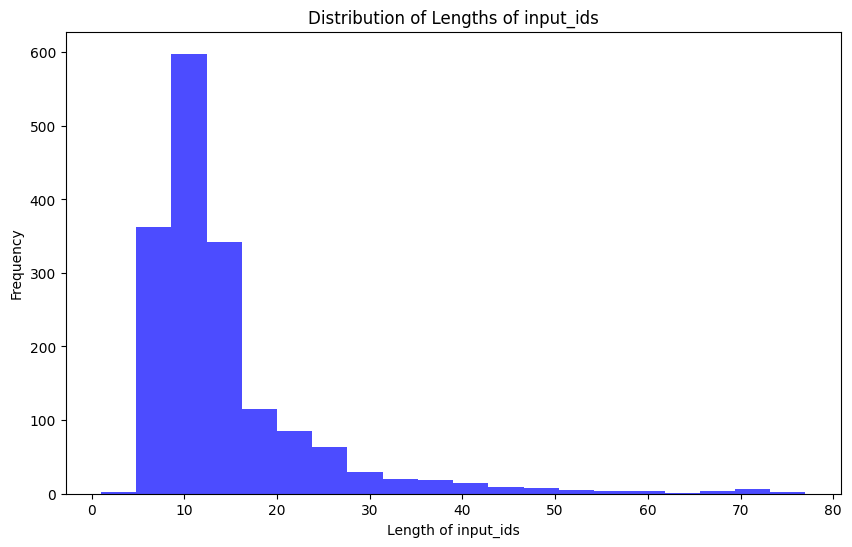

In [70]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(lengths)
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [60]:
max_length = int(max_token) # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [115]:
out

Dataset({
    features: ['text'],
    num_rows: 4
})

In [61]:
tokenized_train_dataset = train_data['train'].map(generate_and_tokenize_prompt2)
tokenized_val_dataset = train_data['test'].map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1352 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

In [87]:
type(tokenized_train_dataset)

datasets.arrow_dataset.Dataset

In [143]:
def a():
    print(lol2)

def b():
    global lol2
    lol2 = 1
    a()

b()

1


In [3]:
def formatting_func(message):
    text = f"{message['text']}"
    return text

tokenizer = 0
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

max_length = 0
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result


def train_on_text(text):

    # Turn the text string into a dataset so its easier to work with
    captioned_imgs = {
        'text': text.split("\n"),
    }
    from datasets import Dataset
    dataset = Dataset.from_dict(captioned_imgs)

    # Split the data
    splited_data = dataset.train_test_split(test_size=0.2)
    # Accelerator setup
    from accelerate import FullyShardedDataParallelPlugin, Accelerator
    from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

    fsdp_plugin = FullyShardedDataParallelPlugin(
        state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
        optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
    )

    accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


    # WandB setup
    import wandb, os
    wandb.login()

    wandb_project = "journal-finetune"
    os.environ["WANDB_NOTEBOOK_NAME "] = wandb_project
    if len(wandb_project) > 0:
        os.environ["WANDB_PROJECT"] = wandb_project



    # Load the model
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

    base_model_id = "mistralai/Mistral-7B-v0.1"
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")


    # Tokenize the dataset
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        base_model_id,
        padding_side="left",
        add_eos_token=True,
        add_bos_token=True,
        use_fast=False, # needed for now, should be fixed soon
    )
    tokenizer.pad_token = tokenizer.eos_token

    tokenized_train_dataset = splited_data['train'].map(generate_and_tokenize_prompt)
    tokenized_val_dataset = splited_data['test'].map(generate_and_tokenize_prompt)
    


    # Load the dataset
    from matplotlib import pyplot as plt

    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]

    bp = plt.boxplot(lengths)
    plt.close()
    global max_length # Setting this global so the next function can access it
    max_length = int([item.get_ydata()[1] for item in bp['whiskers']][1])


    # Load tokenized dataset with max length
    tokenized_train_dataset = splited_data['train'].map(generate_and_tokenize_prompt2)
    tokenized_val_dataset = splited_data['test'].map(generate_and_tokenize_prompt2)


    # Lora setup
    from peft import prepare_model_for_kbit_training

    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)


    from peft import LoraConfig, get_peft_model

    config = LoraConfig(
        r=32,
        lora_alpha=64,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head",
        ],
        bias="none",
        lora_dropout=0.05,  # Conventional
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(model, config)

    # Setup model parallelism for multi-GPU
    if torch.cuda.device_count() > 1: # If more than 1 GPU
        model.is_parallelizable = True
        model.model_parallel = True

    # Load accelerators
    model = accelerator.prepare_model(model)

    # Train
    import transformers
    from datetime import datetime

    project = "journal-finetune"
    base_model_name = "mistral"
    run_name = base_model_name + "-" + project
    output_dir = "./" + run_name

    trainer = transformers.Trainer(
        model=model,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        args=transformers.TrainingArguments(
            output_dir=output_dir,
            warmup_steps=1,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=1,
            gradient_checkpointing=True,
            max_steps=500,
            learning_rate=2.5e-5, # Want a small lr for finetuning
            bf16=True,
            optim="paged_adamw_8bit",
            logging_steps=25,              # When to start reporting loss
            logging_dir="./logs",        # Directory for storing logs
            save_strategy="steps",       # Save the model checkpoint every logging step
            save_steps=25,                # Save checkpoints every 50 steps
            evaluation_strategy="steps", # Evaluate the model every logging step
            eval_steps=25,               # Evaluate and save checkpoints every 50 steps
            do_eval=True,                # Perform evaluation at the end of training
            report_to="wandb",           # Comment this out if you don't want to use weights & baises
            run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",          # Name of the W&B run (optional)
            load_best_model_at_end=True,
            overwrite_output_dir=True
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    trainer.train()

In [ ]:
def formatting_func(message):
    text = f"{message['text']}"
    return text

tokenizer = 0
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

max_length = 0
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result


def train_on_text(text):
    # Accelerator setup
    from accelerate import FullyShardedDataParallelPlugin, Accelerator
    from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

    fsdp_plugin = FullyShardedDataParallelPlugin(
        state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
        optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
    )

    accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


    # WandB setup
    import wandb, os
    wandb.login()

    wandb_project = "journal-finetune"
    os.environ["WANDB_NOTEBOOK_NAME "] = wandb_project
    if len(wandb_project) > 0:
        os.environ["WANDB_PROJECT"] = wandb_project



    # Load the model
    import torch
    from transformers import AutoTokenizer, AutoModelForCausalLM
    base_model_id = "microsoft/phi-2"
    model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)


    # Turn the text string into a dataset so its easier to work with
    captioned_imgs = {
        'text': text.split("\n"),
    }
    from datasets import Dataset
    dataset = Dataset.from_dict(captioned_imgs)

    # Split the data
    splited_data = dataset.train_test_split(test_size=0.2)


    # Tokenize the dataset
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        base_model_id,
        padding_side="left",
        add_eos_token=True,
        add_bos_token=True,
        use_fast=False, # needed for now, should be fixed soon
    )
    tokenizer.pad_token = tokenizer.eos_token

    tokenized_train_dataset = splited_data['train'].map(generate_and_tokenize_prompt)
    tokenized_val_dataset = splited_data['test'].map(generate_and_tokenize_prompt)
    


    # Load the dataset
    from matplotlib import pyplot as plt

    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]

    bp = plt.boxplot(lengths)
    plt.close()
    global max_length # Setting this global so the next function can access it
    max_length = int([item.get_ydata()[1] for item in bp['whiskers']][1])


    # Load tokenized dataset with max length
    tokenized_train_dataset = splited_data['train'].map(generate_and_tokenize_prompt2)
    tokenized_val_dataset = splited_data['test'].map(generate_and_tokenize_prompt2)


    # Lora setup
    from peft import LoraConfig, get_peft_model

    config = LoraConfig(
        r=32,
        lora_alpha=64,
        target_modules=[
            "Wqkv",
            "fc1",
            "fc2",
        ],
        bias="none",
        lora_dropout=0.05,  # Conventional
        task_type="CAUSAL_LM",
    )

    model = get_peft_model(model, config)

    # Load accelerators
    model = accelerator.prepare_model(model)

    # Setup model parallelism for multi-GPU
    if torch.cuda.device_count() > 1: # If more than 1 GPU
        model.is_parallelizable = True
        model.model_parallel = True


    # Train
    import transformers
    from datetime import datetime

    project = "journal-finetune"
    base_model_name = "phi2"
    run_name = base_model_name + "-" + project
    output_dir = "./" + run_name

    trainer = transformers.Trainer(
        model=model,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        args=transformers.TrainingArguments(
            output_dir=output_dir,
            warmup_steps=1,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=1,
            max_steps=500,
            learning_rate=2.5e-5, # Want a small lr for finetuning
            optim="paged_adamw_8bit",
            logging_steps=25,              # When to start reporting loss
            logging_dir="./logs",        # Directory for storing logs
            save_strategy="steps",       # Save the model checkpoint every logging step
            save_steps=25,                # Save checkpoints every 50 steps
            evaluation_strategy="steps", # Evaluate the model every logging step
            eval_steps=25,               # Evaluate and save checkpoints every 50 steps
            do_eval=True,                # Perform evaluation at the end of training
            report_to="wandb",           # Comment this out if you don't want to use weights & baises
            run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",          # Name of the W&B run (optional)
            load_best_model_at_end=True,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    trainers_result = trainer.train()

    return trainers_result

In [11]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [4]:
train_result = train_on_text("keke\ntesting\n123\ntesting this crazy thing lol")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
25,10.586200,7.511251
50,3.315000,6.073570
75,1.160600,5.812877
100,0.923300,5.820731
125,1.057600,5.916906
150,0.964500,6.133241
175,0.994400,5.821979
200,1.126800,5.888299
225,1.011400,5.923133
250,0.958800,5.962177


Checkpoint destination directory ./phi2-journal-finetune/checkpoint-25 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-finetune/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-finetune/checkpoint-75 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-finetune/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-finetune/checkpoint-125 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-finetune/checkpoint-150 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./phi2-journal-f

In [5]:
train_result

TrainOutput(global_step=500, training_loss=1.5777579193115234, metrics={'train_runtime': 325.6374, 'train_samples_per_second': 3.071, 'train_steps_per_second': 1.535, 'total_flos': 72220308480000.0, 'train_loss': 1.5777579193115234, 'epoch': 250.0})

In [7]:
import json

# phi2-journal-finetune/checkpoint-100/trainer_state.json
with open("phi2-journal-finetune/checkpoint-100/trainer_state.json", "r") as f:
    data = json.load(f)

data

{'best_metric': None,
 'best_model_checkpoint': None,
 'epoch': 50.0,
 'eval_steps': 25,
 'global_step': 100,
 'is_hyper_param_search': False,
 'is_local_process_zero': True,
 'is_world_process_zero': True,
 'log_history': [{'epoch': 12.5,
   'learning_rate': 2.3797595190380762e-05,
   'loss': 10.5862,
   'step': 25},
  {'epoch': 12.5,
   'eval_loss': 7.511250972747803,
   'eval_runtime': 0.3253,
   'eval_samples_per_second': 3.074,
   'eval_steps_per_second': 3.074,
   'step': 25},
  {'epoch': 25.0,
   'learning_rate': 2.2545090180360722e-05,
   'loss': 3.315,
   'step': 50},
  {'epoch': 25.0,
   'eval_loss': 6.073570251464844,
   'eval_runtime': 0.2672,
   'eval_samples_per_second': 3.743,
   'eval_steps_per_second': 3.743,
   'step': 50},
  {'epoch': 37.5,
   'learning_rate': 2.1292585170340683e-05,
   'loss': 1.1606,
   'step': 75},
  {'epoch': 37.5,
   'eval_loss': 5.812877178192139,
   'eval_runtime': 0.264,
   'eval_samples_per_second': 3.788,
   'eval_steps_per_second': 3.788,


In [110]:
intputfor = "kek\nkek2\nlmfao\nlol"

captioned_imgs = {
    'text': intputfor.split("\n"),
}
from datasets import Dataset
out = Dataset.from_dict(captioned_imgs)
type(out)

datasets.arrow_dataset.Dataset

In [112]:
out.train_test_split(test_size=0.2)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [99]:
out['text']

['kek', 'kek2', 'lmfao', 'lol']

In [94]:
tokenized_train_dataset

Dataset({
    features: ['note', 'input_ids', 'attention_mask'],
    num_rows: 1352
})

Generally, each `input_ids` should be padded on the left with the `eos_token` (50256) and there should be an `eos_token` 50256 added to the end, and the prompt should start with a `bos_token` (?). However, I'm getting an error with Phi-2's tokenizer. GPU credits for whoever can resolve this!

Hopefully should work just fine as-is.

In [62]:
print(tokenized_train_dataset[1]['input_ids'])

[50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 41, 3643, 40766, 13109, 25, 326, 2576, 287, 11620, 15224, 3073, 588, 616, 409, 986]


Now all the samples should be the same length, `max_length`.

[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,

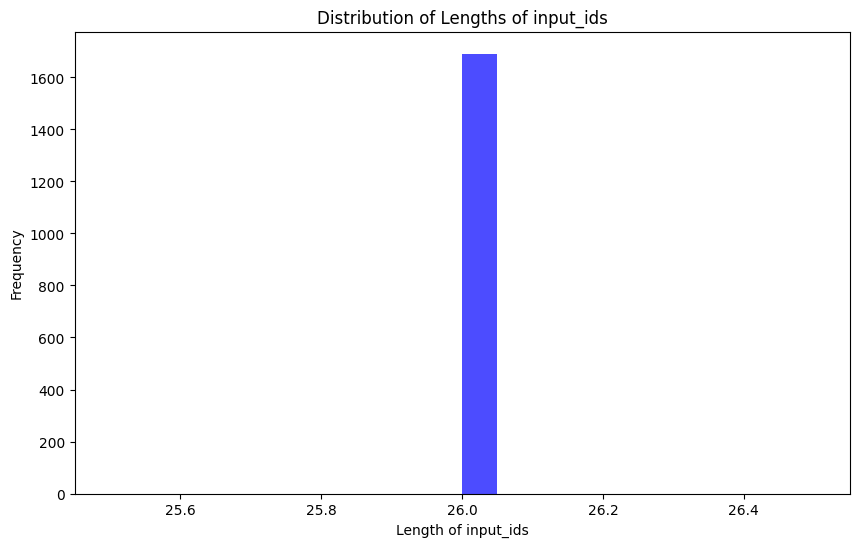

In [63]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Phi-2 does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [171]:
eval_prompt = """ Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55

### Health Score:
"""

The `eval_prompt` I used was:

In [172]:
eval_prompt = " Bro what "

In [173]:
# Init an eval tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Bro what 
The.
A new study has found that the use of a common painkiller during pregnancy may increase the risk for autism in children, according to Reuters Health. The findings were published online on May 1st by JAMA Pediatrics.
Researchers from the University of Montreal and McGill University looked at data from more than 100,000 Quebec families with children born between 1998 and 2009. They compared rates of autism spectrum disorder (ASD) among those who had taken acetaminophen while pregnant or breastfeeding their child versus those who did not take it.
They found that women who took acetaminophen during any trimester were about 30 percent more likely to have a child diagnosed with ASD than mothers who didn’t take the drug. This increased risk was seen even after taking into account other factors such as age, race/ethnicity, education level, income, smoking status, alcohol consumption, and whether or not the mother used antidepressants or anti-anxiety medications during pregnancy

Observe how the model does out of the box. This is clearly not my journal, lol.

### 5. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. Let's set up our LoRA layers.

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to some linear layers of the model. Those layers are `Wqkv`, `fc1`, `fc2`.

In [175]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [29]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


See how the model looks different now, with the LoRA adapters added:

In [177]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default): D

### 6. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`phi2-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [33]:
model = accelerator.prepare_model(model)

In [34]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [35]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=1000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss,Validation Loss
25,5.008900,3.715407
50,3.086600,2.918754
75,2.635100,2.789069
100,2.852500,2.758425
125,2.947600,2.720184
150,2.501300,2.679551
175,2.681600,2.677647
200,2.700300,2.652142
225,2.853800,2.643387
250,2.468700,2.645583


TrainOutput(global_step=1000, training_loss=2.6149856567382814, metrics={'train_runtime': 1328.9813, 'train_samples_per_second': 1.505, 'train_steps_per_second': 0.752, 'total_flos': 1925874892800000.0, 'train_loss': 2.6149856567382814, 'epoch': 1.48})

### 7. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [24]:
pip install -U openai-whisper

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 KB 10.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801382 sha256=699ef94d73f54d81f9c8b469e0fb145bff020c0bcf9651e680fe1569d056dcba
  Stored in directory: /home/jorge/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pydub import AudioSegment

wav_audio = AudioSegment.from_file("WhatsApp Audio 2024-02-08 at 10.54.09_d9abe4f6.waptt.opus")

# Save it
wav_audio.export("output.wav", format="wav")

<_io.BufferedRandom name='output.wav'>

In [4]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("output.wav")
print(result["text"])

 Pode passar uma dica para eles, ele precisa um lugar, um rio que tem muita viú, tipo um vídeo específico que tem, você quantos milhões de viú, no Instagram, por exemplo, aí nesse vídeo ele criou uma página dele de Instagram só para que a postante, essas coisas, tem que ter, aí ele posta reposta esses vídeos, aparecendo e sabe quando você quando se faz aquela, quando você se é sobre a posição, acho que é que você fica comentando sobre o vídeo, aí você pode pegar e colocar, eu vi um exemplo do cara, ele colocou um vídeo do um cara que bateu muita visualização, que era sobre o zoom, de uma câmera lá especial, aí ele pegou aí e falou assim tipo um, essa é falar um que isso é que é o zoom do da câmera do iPhone, será que é mesmo? aí aí, aí tipo só dele colocar isso, o povo começa espamático, use o a, fala mal, os caras, por que ele criou, ele pega um vídeo que tem muito alcance, tem que ser um vídeo que já teve muito alcance, se remixa e faz alguma, tem alguma coisa assim, não é, não é, se

In [181]:
model.config.use_cache = True

In [69]:
torch.cuda.memory_allocated()

3529541120

In [1]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token


from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "phi2-journal-finetune/checkpoint-450")


def inference_on_text(text, max_new_tokens=100, temperature=0.5):
    model_input = eval_tokenizer(text, return_tensors="pt").to("cuda")

    ft_model.eval()
    with torch.no_grad():
        return eval_tokenizer.decode(ft_model.generate(
            **model_input, 
            max_new_tokens=max_new_tokens, 
            repetition_penalty=1.51,
            temperature=temperature, 
            do_sample=True
            )[0], skip_special_tokens=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
inference_on_text('Translate this to Portuguese: "Hello my name is John"', max_new_tokens=30, temperature=.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Translate this to Portuguese: "Hello my name is John" \nAnswer: Olá, meu nome éJohn. The translation from English language into portuguese includes the word order and grammar structure'

In [68]:
del ft_model
del base_model
del tokenizer
del eval_tokenizer

NameError: name 'ft_model' is not defined

In [66]:
import torch

import gc

torch.cuda.empty_cache()
# Only use following if not working with multiple processes sharing GPU mem
# Ensures that all unneeded IPC handles are released and that GPU memory is being used efficiently
torch.cuda.ipc_collect()
gc.collect()
print("GPU cache has been cleared.")

GPU cache has been cleared.


In [8]:
inference_on_text("hello")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'hello@the-council.org\nThe Council of Europe is an international organisation that promotes democracy, human rights and the rule law in 47 European countries through its member states as well as by working with other organisations around world to promote these values globally.. The council was founded on 12th December 1949 at a conference held after World War II when it became clear there needed be some form or structure for cooperation between nations who had suffered so much during this period; they wanted peace but also justice which would'

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "phi2-journal-finetune/checkpoint-875")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [4]:
eval_prompt = " yo bro "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.51)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yo bro ikr u? im so bored lol i dont even know what to do with my life right now but at least we have each other and our phones for entertainment haha cuz thats all that matters anyways https://www.youtube.com/watchv=_q-Yf9QW0c8&siidx=-1%2C5h3X4Vw6KJ7kzUiFjMmEuOyZpPnHg
